In [1]:
import yt
from yt import YTArray
from yt import YTQuantity

from astropy import constants as const

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import SymLogNorm, LogNorm

import palettable
from palettable.colorbrewer.sequential import Blues_8
import palettable.colorbrewer as brew

In [2]:
folder = 'test'
output = 3
ds = yt.load('/simons/scratch/ibutsky/simulations/%s/DD%04d/DD%04d'%\
                 (folder, output, output))

def _drho_over_rho(field, data):
    z = data[('gas', 'z')]
    rho = data[('gas', 'density')]
    print(np.shape(z))
    res = int( abs(z[0] - z[-1]) / abs(z[0] - z[1])) + 1
    drho_over_rho = np.zeros(len(z))
    
    for i in range(res):
        mask = z == z[i]
        ave_rho = np.mean(rho[mask])
        drho_over_rho[mask] = (rho[mask] - ave_rho) / ave_rho
    return drho_over_rho 
    
    
def _accel_z(field, data):
    accel_unit = ds.length_unit.value / ds.time_unit.value**2
    accel = data[('enzo', 'External_Acceleration_z')] * accel_unit
    return YTArray(accel, 'cm/s**2')

def _ff_time(field, data):
    z = data[('gas', 'z')]
    z_midpoint = (z[-1] - z[0]) / 2.0
    z -= z_midpoint
    return np.sqrt(abs(2.0 * z / data[('gas', 'external_acceleration_z')]))

def _cool_ff_ratio(field, data):
    return data[('gas', 'cooling_time')] / data[('gas', 'free_fall_time')]

def _cool_test(field, data):
    L0 =  4.490093e-19
    kb = const.k_B.cgs.value
    rho = data[('gas', 'density')].in_units('g/cm**3')
    T = data[('gas', 'temperature')]
    mu = 1.22
    mh = const.m_p.cgs.value
    
    cool_time = 3*kb * mu * mh * np.power(T, 5./3.) / (2 * rho * L0)
    return YTArray(cool_time.d, 's')

    

def load(output, folder = 'tcool_tff_10'):
    ds = yt.load('/simons/scratch/ibutsky/simulations/%s/DD%04d/DD%04d'%\
                 (folder, output, output))

    #ds.add_field(('gas', 'density_fluctuation'), function = _drho_over_rho, \
    #             display_name = 'Density Fluctuation', units = '')
    ds.add_field(('gas', 'external_acceleration_z'), function = _accel_z, \
                display_name = 'External Acceleration Z', units = 'cm/s**2')

    ds.add_field(('gas', 'free_fall_time'), function = _ff_time, \
                display_name = 'Free Fall Time', units = 's')

    ds.add_field(('gas', 'tcool_tff_ratio'), function = _cool_ff_ratio, \
                display_name = 'Cooling Time / Free Fall Time', units = '')
    ds.add_field(('gas', 'cool_time_test'), function = _cool_test, \
                display_name = 'Cooling Time (test)', units = 'yr')
    
    return ds

def calculate_density_fluctuation(ad, rho0 = 1e-27):
    
    x = ad[('gas', 'x')].in_units('kpc')
    y = ad[('gas', 'y')].in_units('kpc')
    z = ad[('gas', 'z')].in_units('kpc')
    rho = ad[('gas', 'density')].in_units('g/cm**3')
    
    drho_over_rho = np.zeros(len(rho))
    rho_norm = rho / rho0
    resolution = int( abs(z[0] - z[-1]) / abs(z[0] - z[1])) + 2
    resolution = 128
    for i in range(resolution):
        mask = z == z[i]
        ave_rho = np.mean(rho[mask])
        drho_over_rho[mask] = (rho[mask] - ave_rho) / ave_rho

            
    mask = x == x[64]
    xbins = y[mask].reshape(resolution,resolution)
    ybins = z[mask].reshape(resolution,resolution)
    drho = drho_over_rho[mask].reshape(resolution,resolution)
    rho_norm = rho_norm[mask].reshape(resolution, resolution)
    return xbins, ybins, rho_norm, drho

def plot_density_fluctuation_slice(ds, vmin = -1, vmax = 1):
    ad = ds.all_data()
    xbins, ybins, rho_norm, drho = calculate_density_fluctuation(ad)
    fig, ax = plt.subplots(figsize=(12,12))
    #cmap = palettable.cmocean.diverging.Balance_20.mpl_colormap
    cmap = palettable.cmocean.diverging.Curl_9.mpl_colormap
    cmap = palettable.cmocean.diverging.Curl_9.mpl_colormap
    
    print(cmap)
    #norm = SymLogNorm(linthresh=2, linscale=0.03, vmin= -.1, vmax=.1)
    pcm = ax.pcolormesh(xbins, ybins, drho, \
                           cmap = cmap, vmin = vmin, vmax = vmax)
    cbar = fig.colorbar(pcm, pad=0)
    cbar.set_label('Density Fluctuation')
    ax.set_xlabel('y (kpc)')
    ax.set_ylabel('z (kpc)')
    plt.show()


def plot_density_slices(ds, half_range = 0.1, folder = '.', savefig = False):
    ad = ds.all_data()
    xbins, ybins, rho_norm, drho = calculate_density_fluctuation(ad)
    fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=(16,7))

    cmap = palettable.cmocean.sequential.Tempo_20.mpl_colormap
    #norm = SymLogNorm(linthresh=2, linscale=0.03, vmin= -.1, vmax=.1)
    pcm = ax[0].pcolormesh(xbins, ybins, rho_norm, norm = LogNorm(),\
                           cmap = cmap, vmin = 1e-1, vmax = 1)
    cbar = fig.colorbar(pcm, ax = ax[0], pad=0)
    cbar.set_label('Normalized Density')
    ax[0].set_xlabel('y (kpc)')
    ax[0].set_ylabel('z (kpc)')
    
        #cmap = palettable.cmocean.diverging.Balance_20.mpl_colormap
    cmap = palettable.cmocean.diverging.Curl_9.mpl_colormap
    pcm = ax[1].pcolormesh(xbins, ybins, drho, \
                           cmap = cmap, vmin = -half_range, vmax = half_range)
    cbar = fig.colorbar(pcm, ax = ax[1], pad=0)
    cbar.set_label('Density Fluctuation')
    ax[1].set_xlabel('y (kpc)')
    ax[1].set_ylabel('z (kpc)')

    fig.tight_layout()
    if savefig:
        plt.savefig('../plots/%s/%s_density.png'%(folder, ds.basename), dpi = 300)
    else:
        plt.show()
    
    

yt : [INFO     ] 2019-10-11 07:24:28,052 Parameters: current_time              = 0.29999917849411
yt : [INFO     ] 2019-10-11 07:24:28,053 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2019-10-11 07:24:28,054 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-11 07:24:28,055 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-11 07:24:28,056 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2019-10-11 07:25:06,842 Parameters: current_time              = 3.4999990189543
yt : [INFO     ] 2019-10-11 07:25:06,842 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-11 07:25:06,843 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-11 07:25:06,845 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-11 07:25:06,845 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-11 07:25:06,850 Gathering a field list (this may take a moment.)
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Because 'samplin

0.0004458427429199219


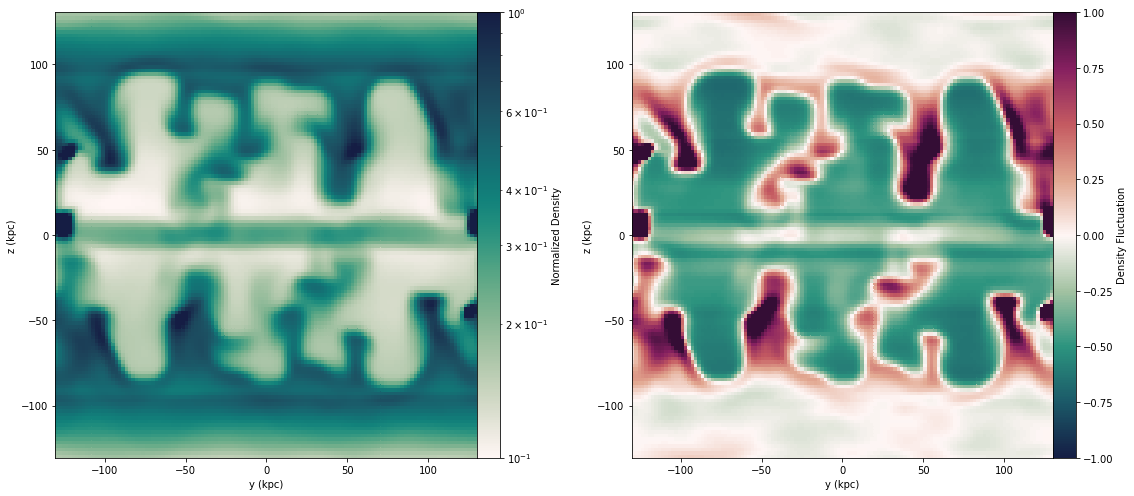


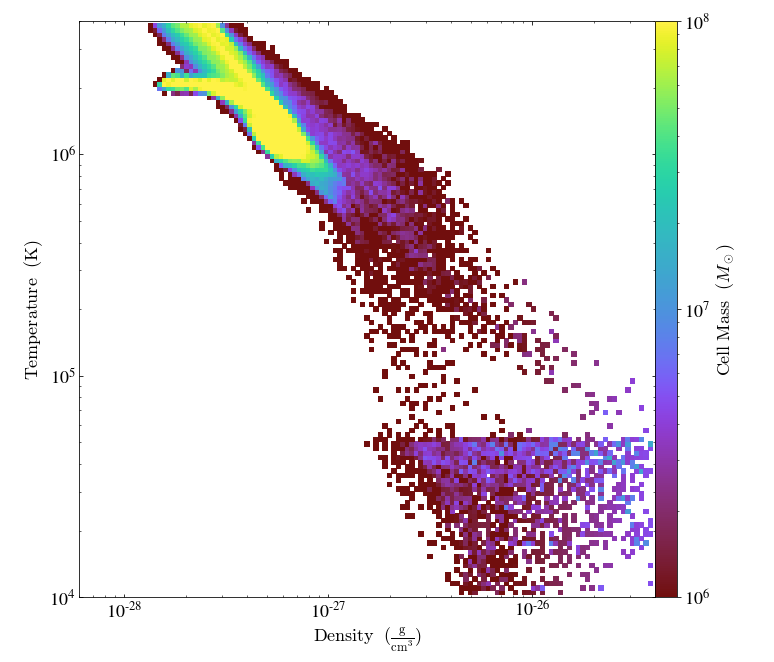


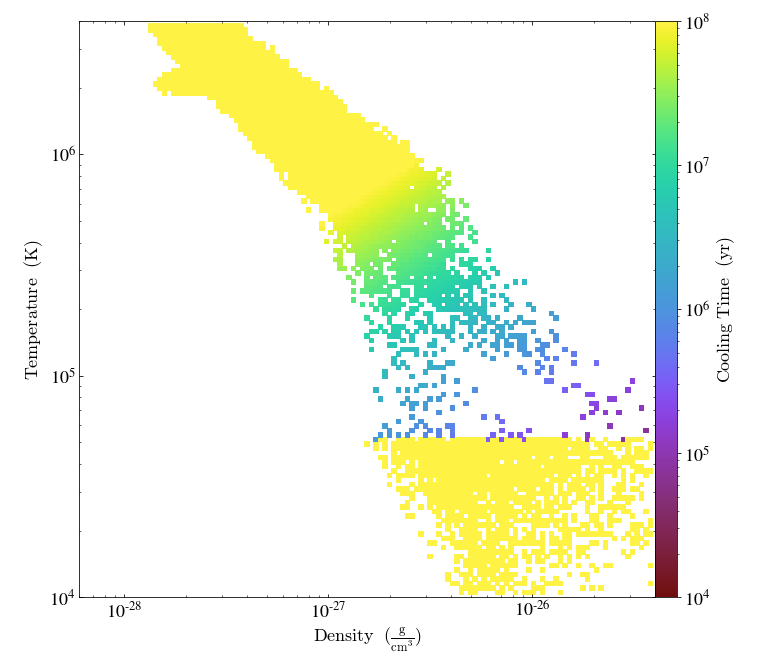

yt : [INFO     ] 2019-10-11 07:25:11,968 Projection completed
yt : [INFO     ] 2019-10-11 07:25:11,969 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:11,970 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:11,970 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:11,971 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:11,972 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



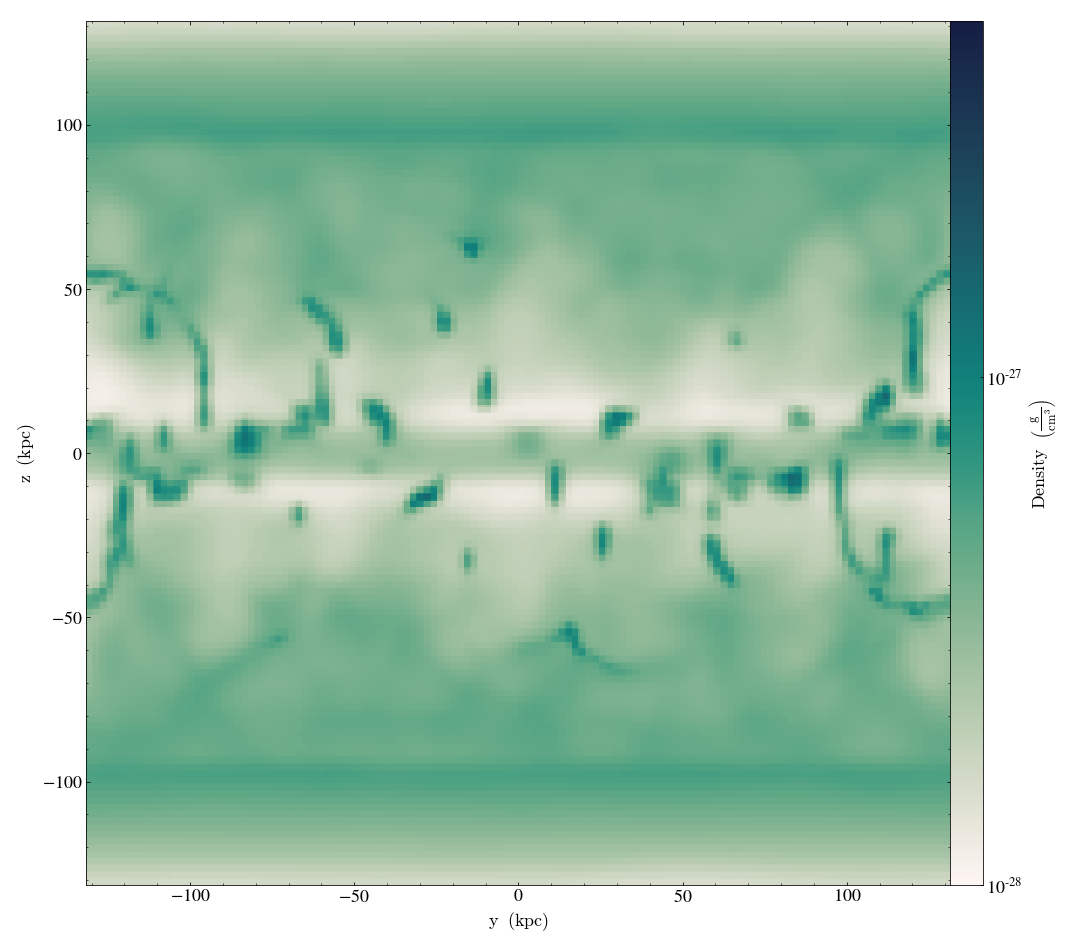

yt : [INFO     ] 2019-10-11 07:25:12,537 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:12,538 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:12,539 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:12,539 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:12,540 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



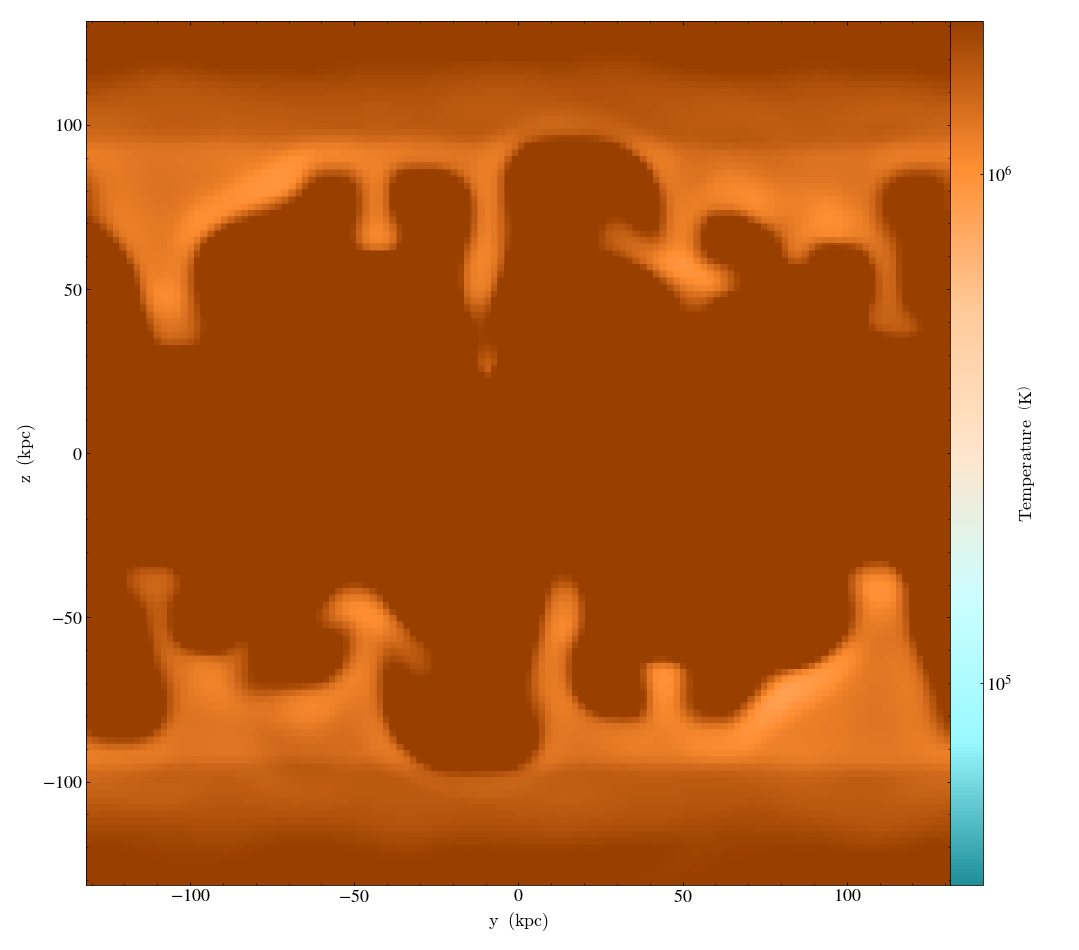

yt : [INFO     ] 2019-10-11 07:25:13,273 Projection completed
yt : [INFO     ] 2019-10-11 07:25:13,274 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:13,275 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:13,276 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:13,276 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-11 07:25:13,277 Making a fixed resolution buffer of (('gas', 'velocity_y')) 800 by 800
yt : [WARNING  ] 2019-10-11 07:25:13,303 Plot image for field ('gas', 'velocity_y') has both positive and negative values. Min = -1436232.589195, Max = 1496676.749237.
yt : [WARNING  ] 2019-10-11 07:25:13,303 Switching to symlog colorbar scaling unless linear scaling is specified later



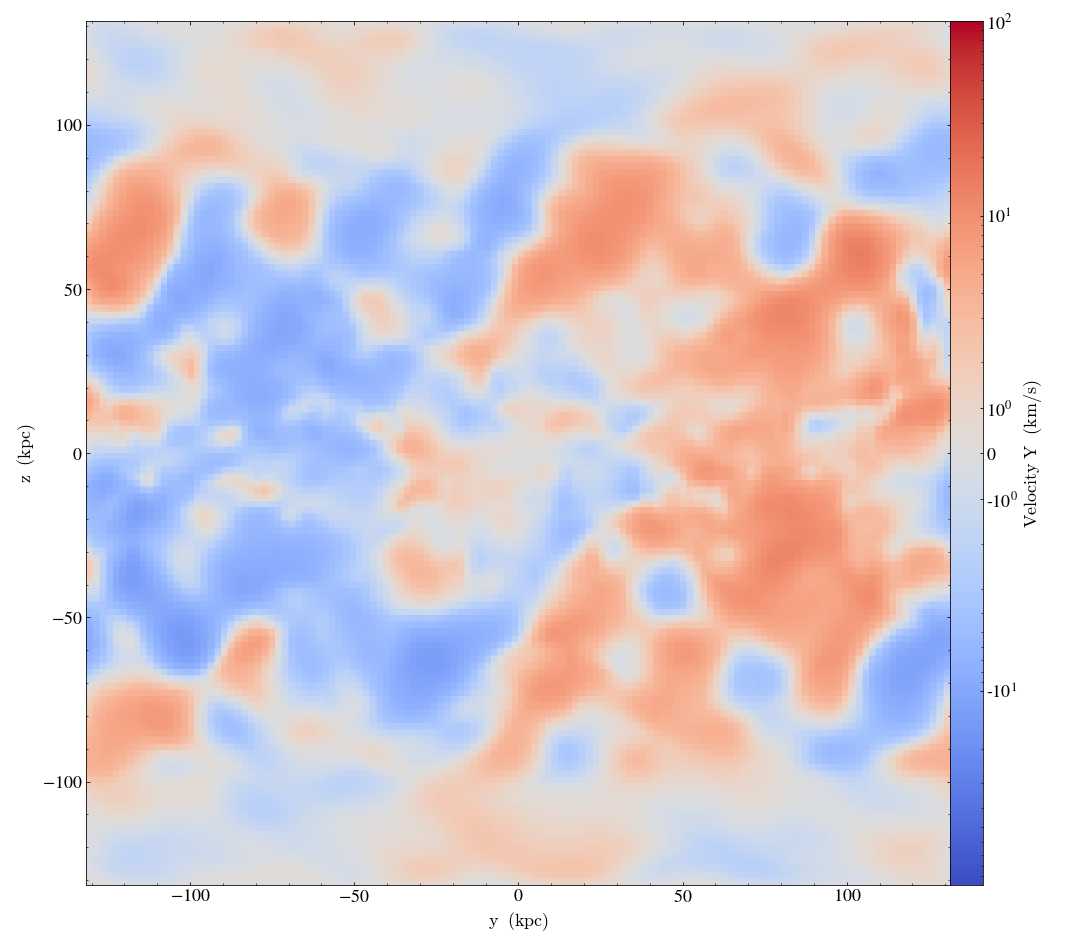

In [5]:
folder = 'isentropic_sf0.01'
#folder = 'isothermal_sf0.01'
folder = 'isothermal'

view = 'x'
for i in [35]:
    ds = load(i, folder = folder)
    ad = ds.all_data()
    rho = ad[('gas', 'density')]
    high_rho = rho[rho > 1e-26]
    print(len(high_rho) / len(rho))

    half_range = 1
    plot_density_slices(ds, half_range = half_range)
    
    p = yt.PhasePlot(ad, ('gas', 'density'), ('gas', 'temperature'), \
                         ('gas', 'cell_mass'), weight_field = None)
    p.set_xlim(6e-29, 4e-26)
    p.set_ylim(1e4, 4e6)
    p.set_unit(('gas', 'cell_mass'), 'Msun')
    p.set_zlim(('gas', 'cell_mass'), 1e6, 1e8)
    p.show()
        
        
    p = yt.PhasePlot(ad, ('gas', 'density'), ('gas', 'temperature'), \
                         ('gas', 'cooling_time'), weight_field = 'ones')
    p.set_xlim(6e-29, 4e-26)
    p.set_ylim(1e4, 4e6)
    p.set_unit(('gas', 'cooling_time'), 'yr')
    p.set_zlim(('gas', 'cooling_time'), 1e4, 1e8)
    p.show()
    
    field = ('gas', 'density')
    s = yt.ProjectionPlot(ds, view, field, window_size = 12, weight_field = 'ones')
 #   s.set_cmap(field, 'coolwarm')
    s.set_zlim(field, 1e-28, 5e-27)
    #s.set_log(field, False)
    s.set_cmap(field, palettable.cmocean.sequential.Tempo_20.mpl_colormap)
    s.show()
    field = ('gas', 'temperature')
    s = yt.SlicePlot(ds, view, field, window_size = 12)
    s.set_cmap(field, 'coolwarm')
    s.set_zlim(field, 4e4, 2e6)
#    s.set_log(field, False)
    s.set_cmap(field, palettable.lightbartlein.diverging.BlueDarkOrange12_7.mpl_colormap)
    s.show()
    

    field = ('gas', 'velocity_y')
    s = yt.ProjectionPlot(ds, view, field, window_size = 12, weight_field = 'ones')
    s.set_cmap(field, 'coolwarm')
    s.set_unit(field, 'km/s')
    s.set_zlim(field, -100, 100)
    #s.set_zlim(field, -1e7, 1e7)
    #s.set_log(field, False)
    s.show()



In [58]:
ad = ds.all_data()
cool_time = ad[('gas', 'cooling_time')].in_units('Myr')
cool_test = ad[('gas', 'cool_time_test')].in_units('Myr')

In [60]:
diff = abs(cool_time - cool_test) / cool_time
#diff = diff.reshape(64, 64, 64)
print(max(diff))

1.249775624577799e-06 dimensionless


In [62]:
s = yt.SlicePlot(ds, 'x', ('gas', 'density'))
frb = s.frb
rho = frb['density']

yt : [INFO     ] 2019-10-10 12:35:15,880 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:35:15,881 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:35:15,882 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:35:15,883 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:35:15,884 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-10-10 12:35:16,007 Making a fixed resolution buffer of (density) 800 by 800


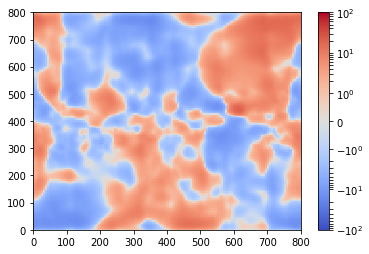

In [59]:
plt.pcolormesh(vy.in_units('km/s'), cmap = 'coolwarm', norm = SymLogNorm(1), vmin = -100, vmax = 100)
cbar = plt.colorbar()

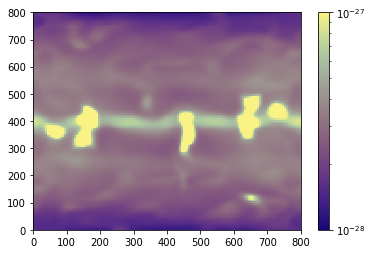

In [71]:
plt.pcolormesh(rho.d, cmap = 'kelp', norm = LogNorm(), vmin = 1e-28, vmax = 1e-27)
cbar = plt.colorbar()

In [74]:
drho = np.zeros((800, 800))
for i in range(len(rho)):
    ave_rho = np.mean(rho[i])
    drho[i] = (rho[i] - ave_rho) / rho[i]
    

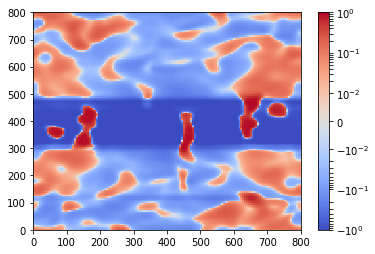

In [78]:
plt.pcolormesh(drho, cmap = 'coolwarm', norm = SymLogNorm(0.01), vmin = -1, vmax = 1)
cbar = plt.colorbar()

yt : [INFO     ] 2019-10-10 12:49:58,500 Projection completed
yt : [INFO     ] 2019-10-10 12:49:58,501 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:49:58,502 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:49:58,503 xlim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:49:58,504 ylim = -2.000000 2.000000
yt : [INFO     ] 2019-10-10 12:49:58,505 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-10-10 12:49:58,739 Making a fixed resolution buffer of (density) 800 by 800


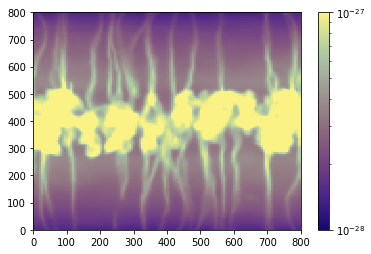

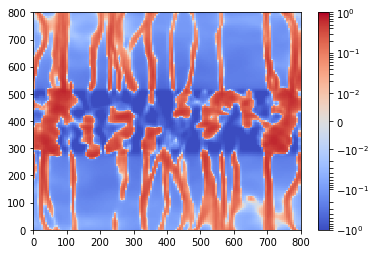

In [80]:
s = yt.ProjectionPlot(ds, 'x', ('gas', 'density'), weight_field = 'ones')
frb = s.frb
rho = frb['density']

drho = np.zeros((800, 800))
for i in range(len(rho)):
    ave_rho = np.mean(rho[i])
    drho[i] = (rho[i] - ave_rho) / rho[i]
    
plt.pcolormesh(rho.d, cmap = 'kelp', norm = LogNorm(), vmin = 1e-28, vmax = 1e-27)
cbar = plt.colorbar()
plt.show()
plt.clf()

plt.pcolormesh(drho, cmap = 'coolwarm', norm = SymLogNorm(0.01), vmin = -1, vmax = 1)
cbar = plt.colorbar()

In [92]:
y = frb['y'].in_units('kpc')
z = frb['z'].in_units('kpc')

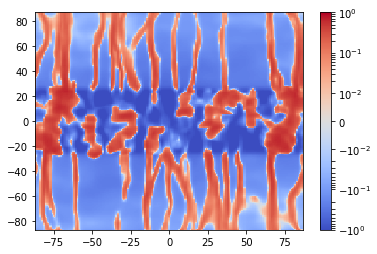

In [95]:
plt.pcolormesh(y, z, drho, cmap = 'coolwarm', norm = SymLogNorm(0.01), vmin = -1, vmax = 1)
cbar = plt.colorbar()